# Data mining Coursework 2023

Part 2: Select an application domain preferably related to your topic above (Data mining for energy forecasting). Pick a data set, possibly available publicly (e.g. diabetes from the UC Irvine Machine Learning Repository) use data mining (e.g. classification, clustering, association rules etc.) to extract knowledge from it. You can use any tool you like (e.g. Weka, RapidMiner). Then go back to preprocess your data set, change algorithm, parameters etc. attempting to extract knowledge out of your data. Describe the process and discuss the results. Which method was more appropriate and why? Detail the algorithmic parameters you used, justify your choices, and discuss the challenges you met and how you overcame these. 

In [1]:
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('NI_hourly.csv') # Read csv file and import it into a pandas dataframe
df = df.set_index('Datetime') # Set index datetime
df.index = pd.to_datetime(df.index)
df2 = df # Copy dataframe

In [3]:
# Show the first 5 rows of dataframe
df.head()

,NI_MW
Datetime,
2004-12-31 01:00:00,9810.0
2004-12-31 02:00:00,9001.0
2004-12-31 03:00:00,8509.0
2004-12-31 04:00:00,8278.0
2004-12-31 05:00:00,8089.0


In [4]:
# Show the shape of the dataframe
df.shape

(58450, 1)

In [5]:
# Show null values of the dataframe
df.isnull().sum()

NI_MW    0
dtype: int64

In [6]:
# Generate descriptive statistics of the dataframe
df.describe()

,NI_MW
count,58450.000000
mean,11701.682943
std,2371.498701
min,7003.000000
25%,9954.000000
50%,11521.000000
75%,12896.750000
max,23631.000000


Text(0.5, 1.0, 'NI Energy Cosumption')

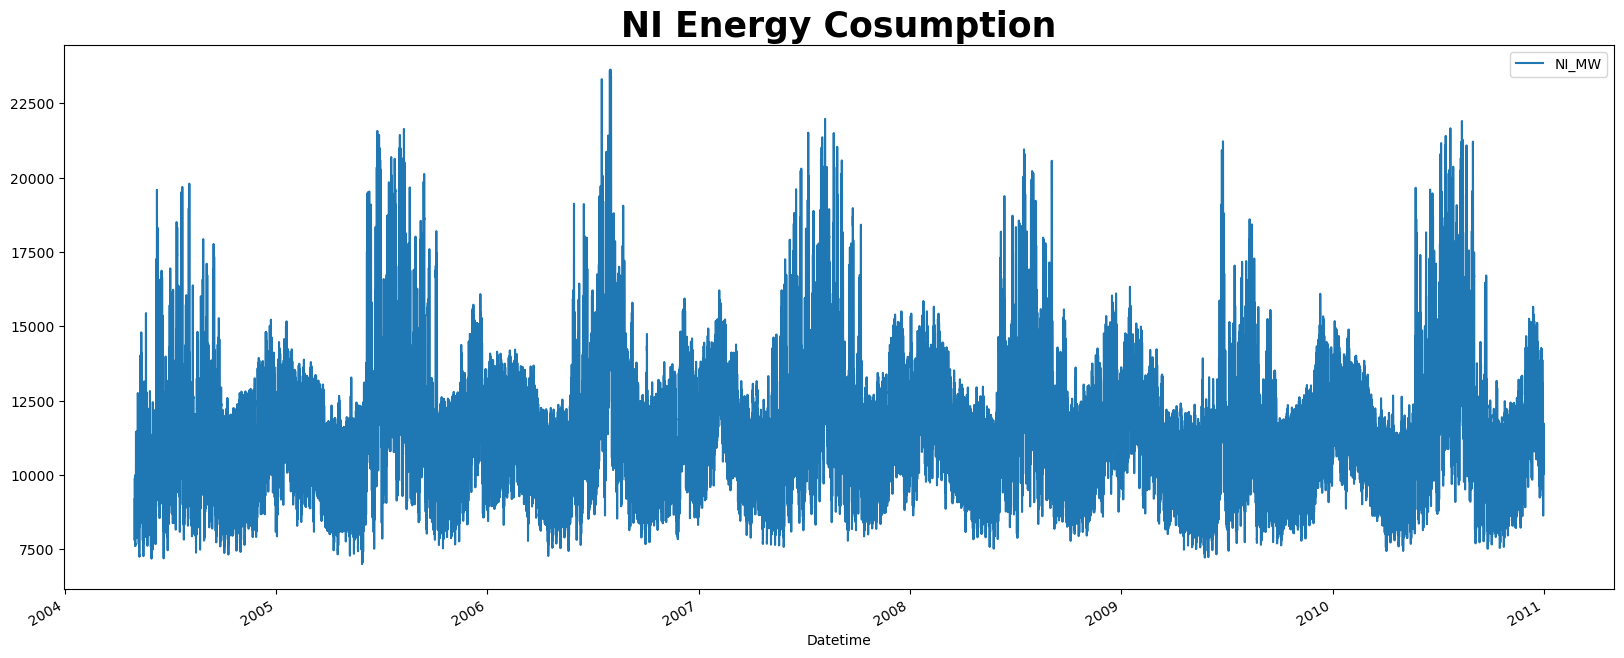

In [7]:
# Visualize data
df.plot(figsize=(20,8))
plt.title('NI Energy Cosumption', weight='bold', fontsize=25)

In [8]:
# Function to plot the train-test split of time series data
def plot_train_test_split(train, test, split_date):
    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
    test.plot(ax=ax, label='Test Set')
    ax.axvline(split_date, color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()

In [9]:
# Function to create a train-test split of a DataFrame based on a given split date
def create_train_test_split(df, split_date):
    train = df.loc[df.index < split_date]
    test = df.loc[df.index >= split_date]
    return train, test

In [10]:
# Create a train-test split of the dataframe using a specified split date(11-01-2009)
train, test = create_train_test_split(df, '11-01-2009')

In [11]:
# Show the shape of the training set
train.shape

(48229, 1)

In [12]:
# Show the shape of the test set
test.shape

(10221, 1)

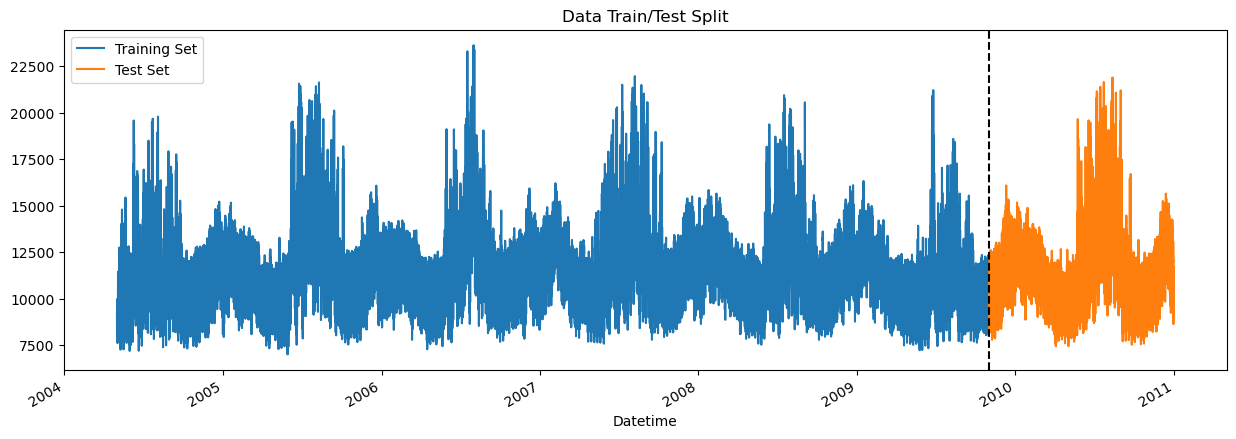

In [13]:
# Plot the train/test split of the time series data
plot_train_test_split(train, test, '11-01-2009')

In [14]:
# Create time series features based on time series index
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [15]:
# Extract time series features from the dataframe
df = create_features(df)

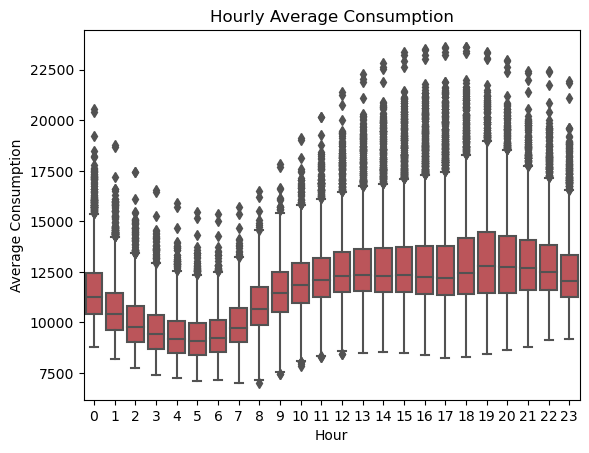

In [16]:
# Visualize hourly average consumption
sns.boxplot(data=df, x='hour', y='NI_MW', color='#cc444b')

plt.xlabel('Hour')
plt.ylabel('Average Consumption')
plt.title('Hourly Average Consumption')

plt.show()

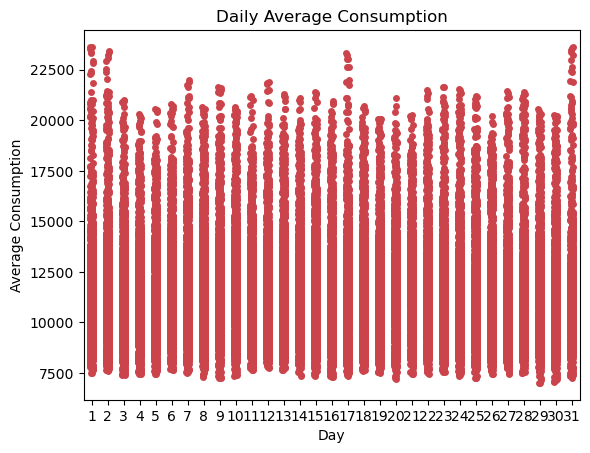

In [17]:
# Visualize daily average consumption
sns.stripplot(data=df, x='dayofmonth', y='NI_MW', color='#cc444b')

plt.xlabel('Day')
plt.ylabel('Average Consumption')
plt.title('Daily Average Consumption')

plt.show()

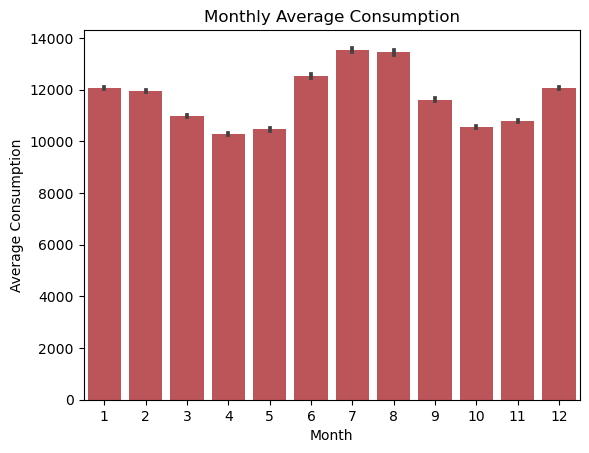

In [18]:
# Visualize monthly average consumption
sns.barplot(data=df, x='month', y='NI_MW', color='#cc444b')

plt.xlabel('Month')
plt.ylabel('Average Consumption')
plt.title('Monthly Average Consumption')

plt.show()

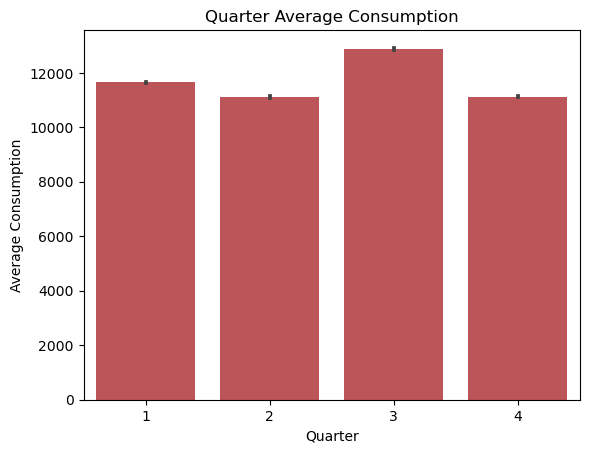

In [19]:
# Visualize quarter average consumption
sns.barplot(data=df, x='quarter', y='NI_MW', color='#cc444b')

plt.xlabel('Quarter')
plt.ylabel('Average Consumption')
plt.title('Quarter Average Consumption')

plt.show()

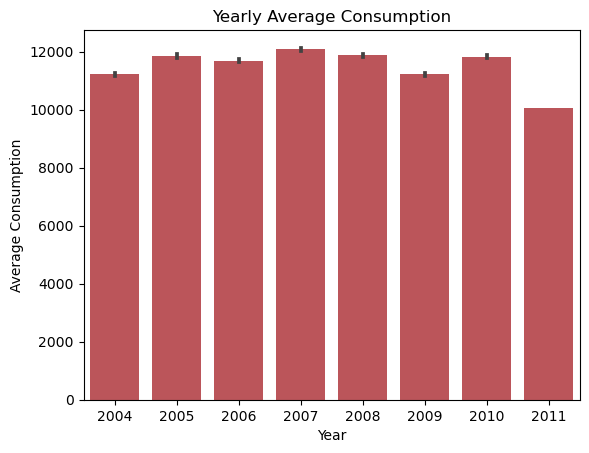

In [20]:
# visualize yearly average consumption
sns.barplot(data=df, x='year', y='NI_MW', color='#cc444b')

plt.xlabel('Year')
plt.ylabel('Average Consumption')
plt.title('Yearly Average Consumption')

plt.show()

In [21]:
# Generate additional features from the dataframe
train = create_features(train)
test = create_features(test)

# Features and target assigned
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'NI_MW'

# Assigned features,target on train and test set respectively
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [22]:
# Show the shape of the training set
X_train.shape

(48229, 6)

In [23]:
# Show the shape of the test set
X_test.shape

(10221, 6)

In [24]:
# Create a function to train an XGB model
def train_xgboost_model(X_train, y_train, X_test, y_test, params):
    reg = xgb.XGBRegressor(**params)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=10,
            verbose=100)
    return reg

In [25]:
# Set the parameters for XGBregressor model
params = {
    'base_score': 0.5,
    'booster': 'gbtree',
    'n_estimators': 1000,
    'objective': 'reg:linear',
    'max_depth': 3,
    'learning_rate': 0.008
}

In [26]:
# Call the function to create an XGB model
reg_xgb = train_xgboost_model(X_train, y_train, X_test, y_test, params)

[15:58:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11837.34199	validation_1-rmse:11884.66872


C:\Users\User\Desktop\sample_project_1\env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:5504.65195	validation_1-rmse:5584.02250
[200]	validation_0-rmse:2811.33665	validation_1-rmse:2929.18347
[300]	validation_0-rmse:1769.98098	validation_1-rmse:1960.52350
[400]	validation_0-rmse:1414.47837	validation_1-rmse:1653.89147
[500]	validation_0-rmse:1294.09428	validation_1-rmse:1535.20989
[600]	validation_0-rmse:1239.74466	validation_1-rmse:1496.57871
[646]	validation_0-rmse:1222.44387	validation_1-rmse:1488.61958


In [27]:
# Create a funtion to plot the feature importance
def plot_feature_importance(model, feature_names, title):
    feature_importance = model.feature_importances_
    fi = pd.DataFrame(data=feature_importance, index=feature_names, columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title=title)
    plt.show()

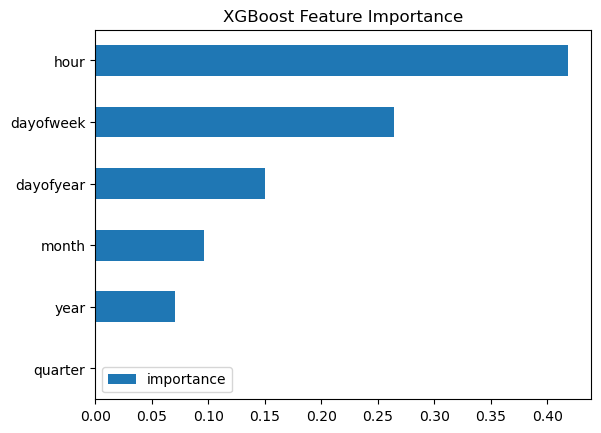

In [28]:
# Call the function to plot the feature importance of the XGB model
plot_feature_importance(reg_xgb, X_train.columns, 'XGBoost Feature Importance')

In [29]:
# Create a function that plots the test data along with the predictions made by a trained model
def plot_test(df, X_test, model):
    prediction = model.predict(X_test)
    df['prediction'] = None  # Initialize 'prediction' column in df
    df.loc[X_test.index, 'prediction'] = prediction  # Assign predictions to corresponding rows in df
    ax = df[['NI_MW']].plot(figsize=(15, 5))
    df['prediction'].plot(ax=ax, style='.')
    plt.legend(['Truth Data', 'Predictions'])
    ax.set_title('Raw Data and Prediction')
    plt.show()
    return df

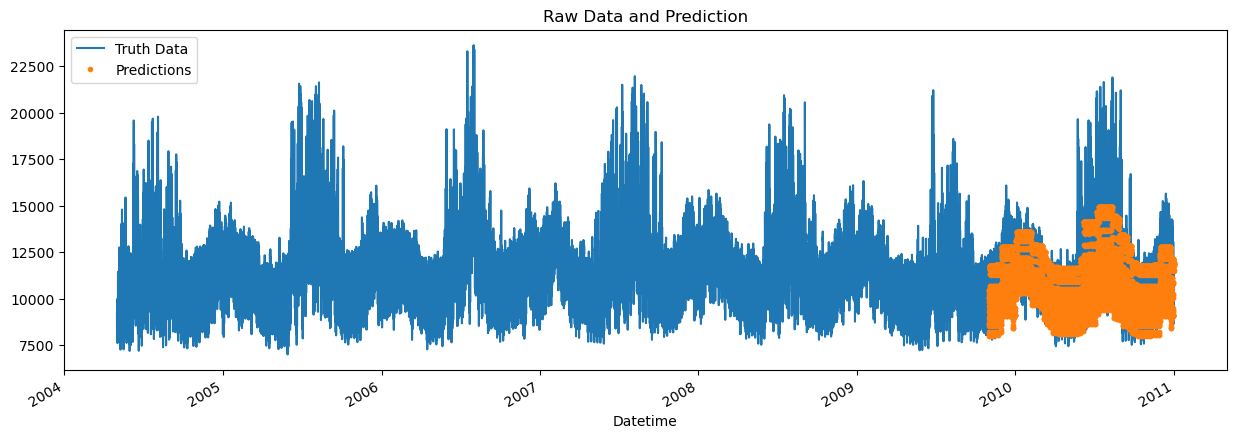

In [30]:
# Call the function to plot the test data along with the predictions
result_df = plot_test(df, X_test, reg_xgb)

In [31]:
# Compute and print the RMSE score of our model
score = np.sqrt(mean_squared_error(test['NI_MW'], df.loc[test.index, 'prediction']))
print(f'RMSE Score (XGB): {score:0.2f}')

RMSE Score (XGB): 1488.27


In [32]:
# Create a function for random forest model
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=4, random_state=42, min_samples_leaf=2):
    # Train the Random Forest model
    reg_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, min_samples_leaf=min_samples_leaf)
    reg_rf.fit(X_train, y_train)

    # Make predictions
    y_pred_rf = reg_rf.predict(X_test)

    # Calculate RMSE
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)

    # Print RMSE
    print(f'(RMSE Score (Random Forest):{rmse_rf:0.2f}')

    # Return the trained model
    return reg_rf

In [33]:
# Call the function to create a random forest model
reg_rf = train_random_forest(X_train, y_train, X_test, y_test)

(RMSE Score (Random Forest):1526.44


In [34]:
#Create a function to visualize tree from the random forest
def visualize_tree_from_random_forest(model, tree_index, feature_names):
    # Get the selected tree
    selected_tree = model.estimators_[tree_index]

    # Plot the tree
    plt.figure(figsize=(25, 15))
    plot_tree(selected_tree, feature_names=feature_names, filled=True)
    plt.show()


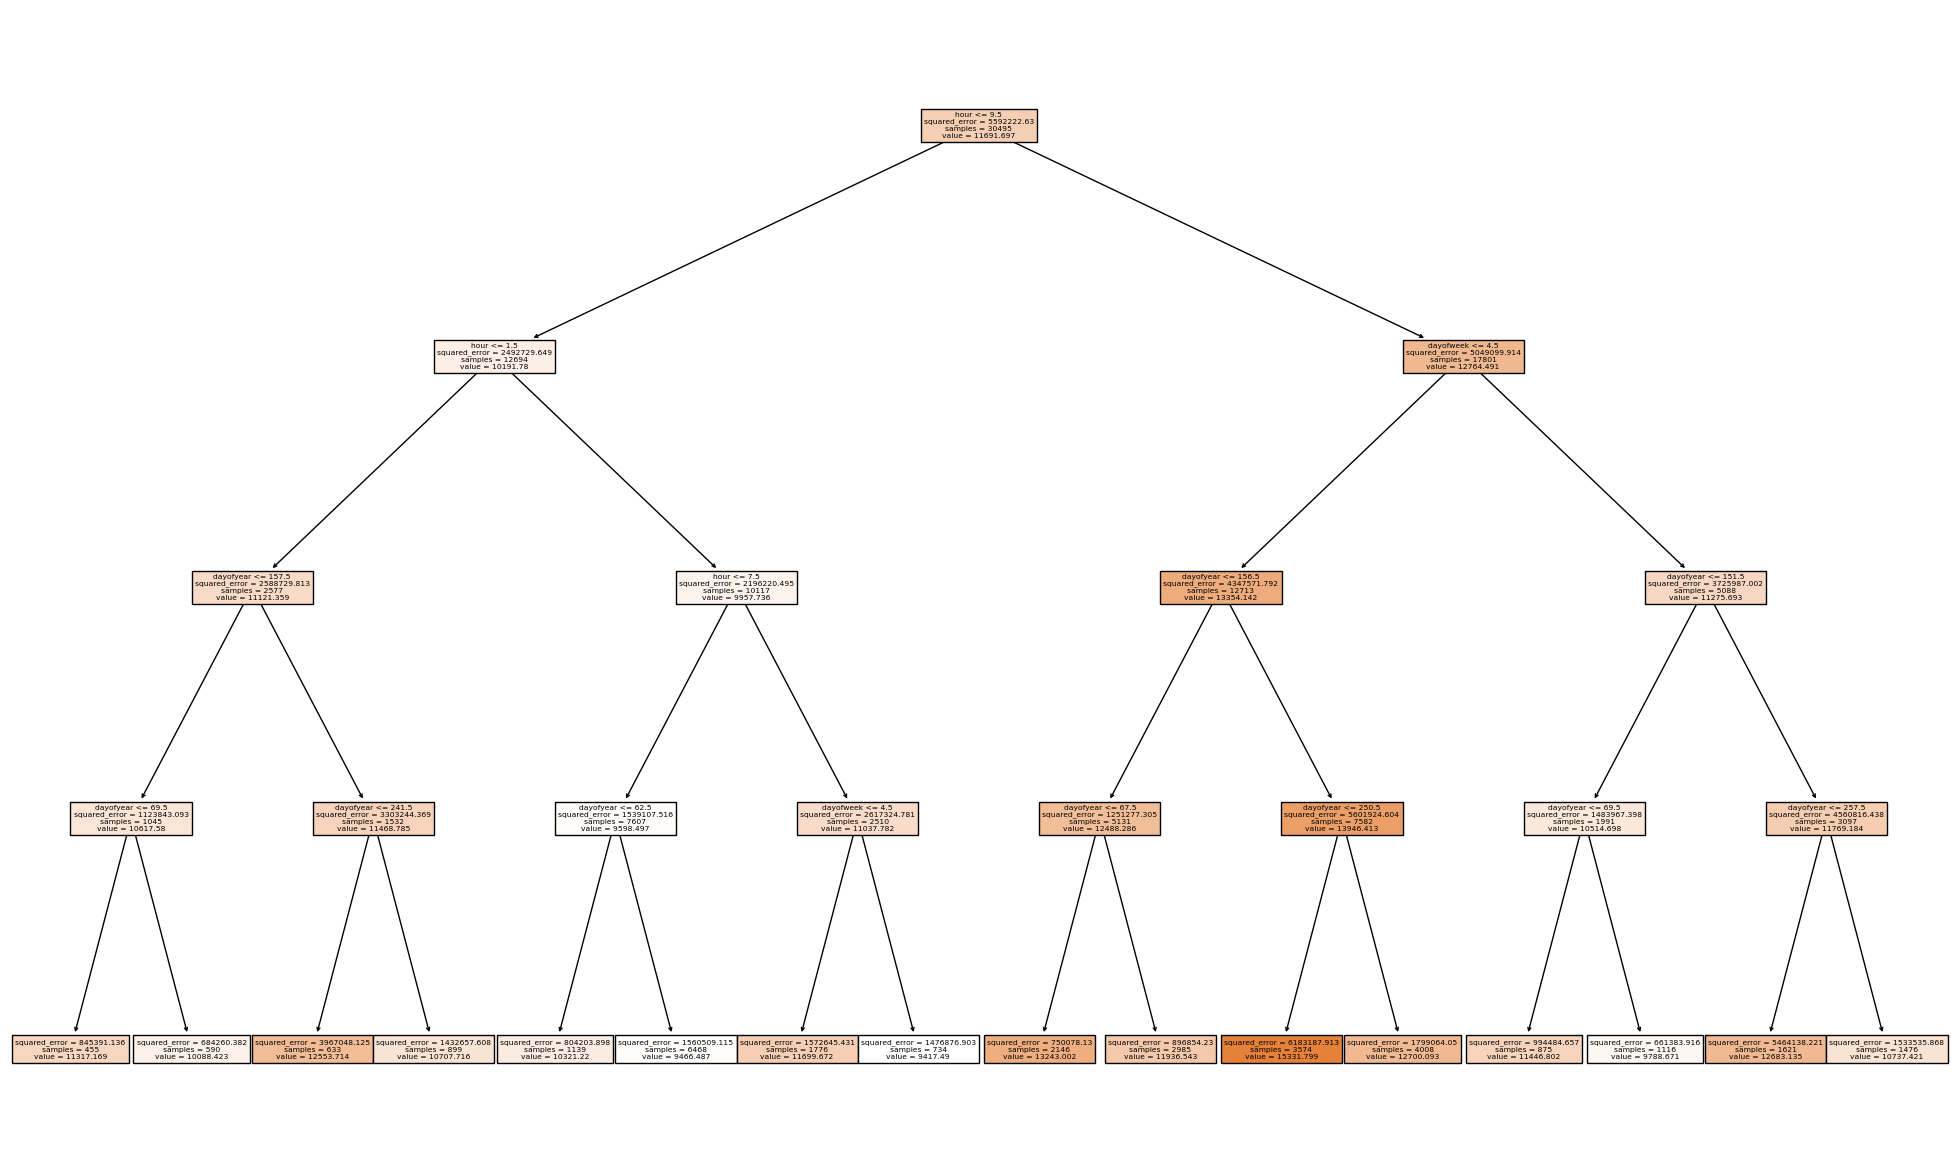

In [35]:
# Call the function to visualize tree from the random forest
visualize_tree_from_random_forest(reg_rf, 0, X_train.columns)

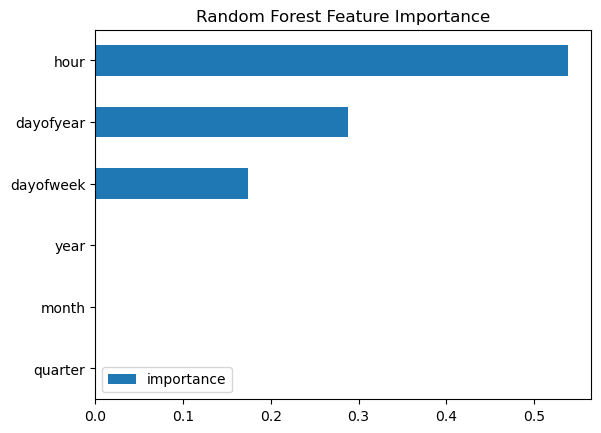

In [36]:
# Call the function to plot the feature importance of the random forest
plot_feature_importance(reg_rf, X_train.columns, 'Random Forest Feature Importance')

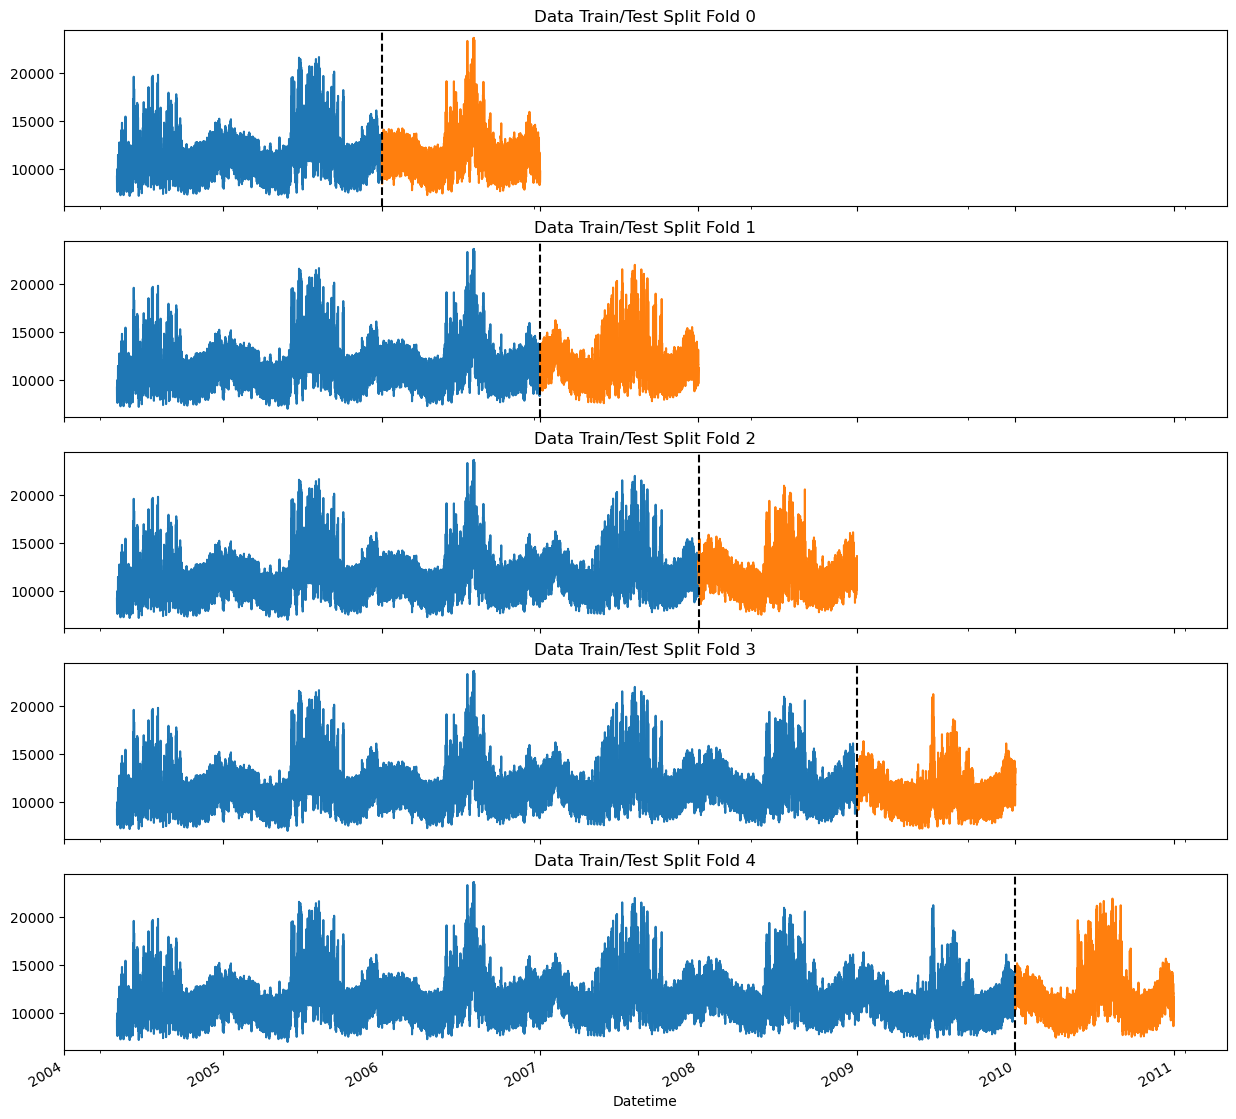

In [37]:
# Plot the time series split for every fold
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['NI_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['NI_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [38]:
# Create a function that add lags in the dataframe
def add_lags(df):
    target_map = df['NI_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [39]:
# Use the function that add lags in the dataframe
df = add_lags(df)

In [61]:
# Create a function to pefrom cross validation with XGB model
def perform_time_series_analysis(df):
    tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
    df = df.sort_index()

    fold = 0
    preds = []
    scores = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        train = create_features(train)
        test = create_features(test)

        FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                    'lag1','lag2','lag3']
        TARGET = 'NI_MW'

        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_test = test[FEATURES]
        y_test = test[TARGET]

        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                               n_estimators=1000,
                               early_stopping_rounds=10,
                               objective='reg:linear',
                               max_depth=3,
                               learning_rate=0.008)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
        score2see=np.mean(scores)
    print(" ")
    print(f'RMSE score across folds: {np.mean(scores):0.2f}')    

In [62]:
# Call the function to perform cross validation
perform_time_series_analysis(df)

[16:00:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11772.42549	validation_1-rmse:11821.87391
[100]	validation_0-rmse:5468.20546	validation_1-rmse:5055.72835
[200]	validation_0-rmse:2757.41904	validation_1-rmse:2311.20918
[300]	validation_0-rmse:1702.63127	validation_1-rmse:1474.07333
[375]	validation_0-rmse:1400.98038	validation_1-rmse:1394.50881
[16:00:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11794.11934	validation_1-rmse:12235.11344
[100]	validation_0-rmse:5477.66839	validation_1-rmse:5781.72700
[200]	validation_0-rmse:2771.22592	validation_1-rmse:3030.75480
[300]	validation_0-rmse:17

# Remove outliers

<AxesSubplot:ylabel='Frequency'>

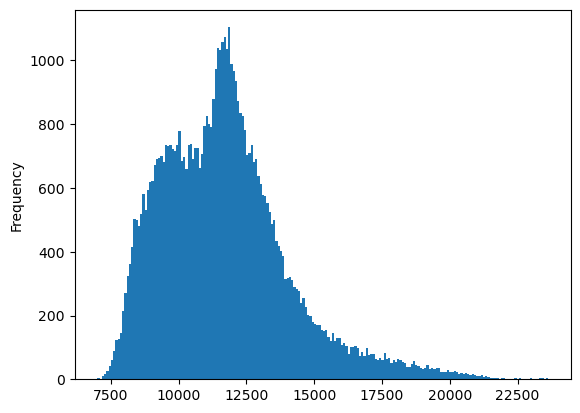

In [42]:
# Visualize our dataset for spotting outliers
df2['NI_MW'].plot(kind='hist', bins=200)

In [43]:
# Find the outliers of the dataset
q1 = df['NI_MW'].quantile(0.25)
q3 = df['NI_MW'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df[(df['NI_MW'] < lower_bound) | (df['NI_MW'] > upper_bound)]
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

Lower bound: 5539.875
Upper bound: 17310.875


In [44]:
# Remove the outliers
filtered_data = df2.query('NI_MW > 17310.875')['NI_MW']
print(f'{len(filtered_data)} data has been removed from the dataset')
df2 = df2.query('NI_MW < 17310.875').copy()

1816 data has been removed from the dataset


In [45]:
# Print the rows of the 2 dataframes
print("Original dataframe:", df.shape[0])
print("New dataframe:", df2.shape[0])

Original dataframe: 58450
New dataframe: 56634


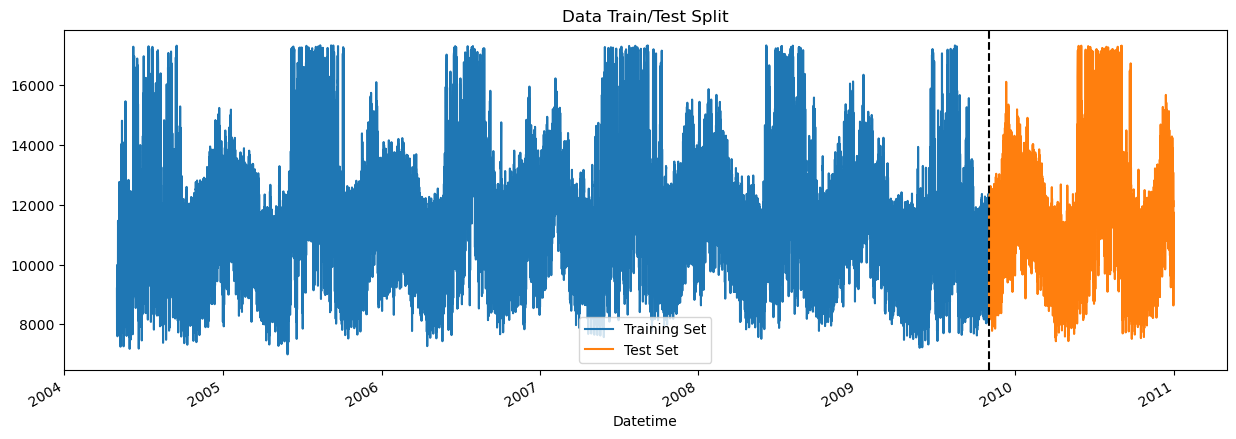

In [46]:
# Create train, test split and plot it
train2, test2 = create_train_test_split(df2, '11-01-2009')
plot_train_test_split(train2, test2, '11-01-2009')

In [47]:
# Extract time series features from the dataframe
df2 = create_features(df2)

In [48]:
# Generate additional features from the dataframe
train2 = create_features(train2)
test2 = create_features(test2)

# Features and target assigned
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'NI_MW'

# Assigned features,target on train and test set respectively
X_train2 = train2[FEATURES]
y_train2 = train2[TARGET]

X_test2 = test2[FEATURES]
y_test2 = test2[TARGET]

In [49]:
# Call the function to create an XGB model
reg_xgb2 = train_xgboost_model(X_train2, y_train2, X_test2, y_test2, params)

[15:59:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11558.94644	validation_1-rmse:11533.92724


C:\Users\User\Desktop\sample_project_1\env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:5330.72670	validation_1-rmse:5331.55074
[200]	validation_0-rmse:2659.23731	validation_1-rmse:2701.38903
[300]	validation_0-rmse:1602.28619	validation_1-rmse:1711.68041
[400]	validation_0-rmse:1233.99810	validation_1-rmse:1383.65951
[500]	validation_0-rmse:1107.54723	validation_1-rmse:1260.56981
[600]	validation_0-rmse:1051.28499	validation_1-rmse:1205.29317
[700]	validation_0-rmse:1020.30488	validation_1-rmse:1182.40055
[727]	validation_0-rmse:1014.14930	validation_1-rmse:1179.62749


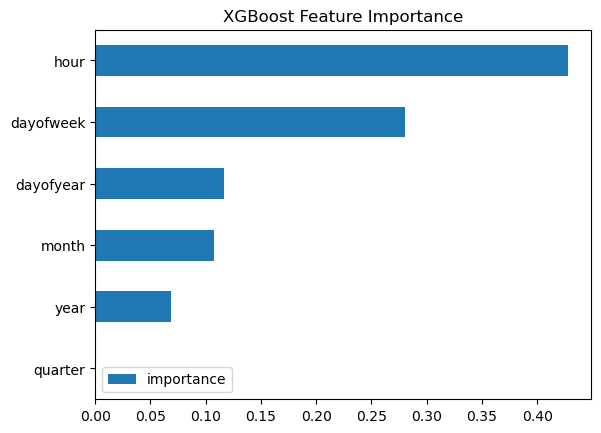

In [50]:
# Call the function to plot the feature importance of the XGB model
plot_feature_importance(reg_xgb2, X_train2.columns, 'XGBoost Feature Importance')

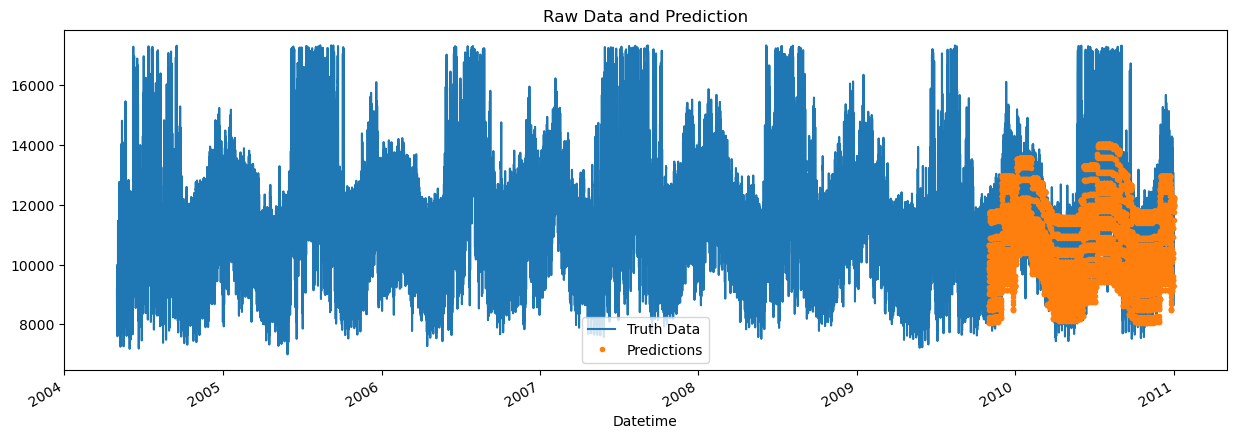

In [51]:
# Call the function to plot the test data along with the predictions
result_df2 = plot_test(df2, X_test2, reg_xgb2)

In [52]:
# Compute and print the RMSE score of our model
score = np.sqrt(mean_squared_error(test2['NI_MW'], df2.loc[test2.index, 'prediction']))
print(f'RMSE Score (XGB): {score:0.2f}')

RMSE Score (XGB): 1179.41


In [53]:
# Call the function to create a random forest model
reg_rf2 = train_random_forest(X_train2, y_train2, X_test2, y_test2)

(RMSE Score (Random Forest):1347.36


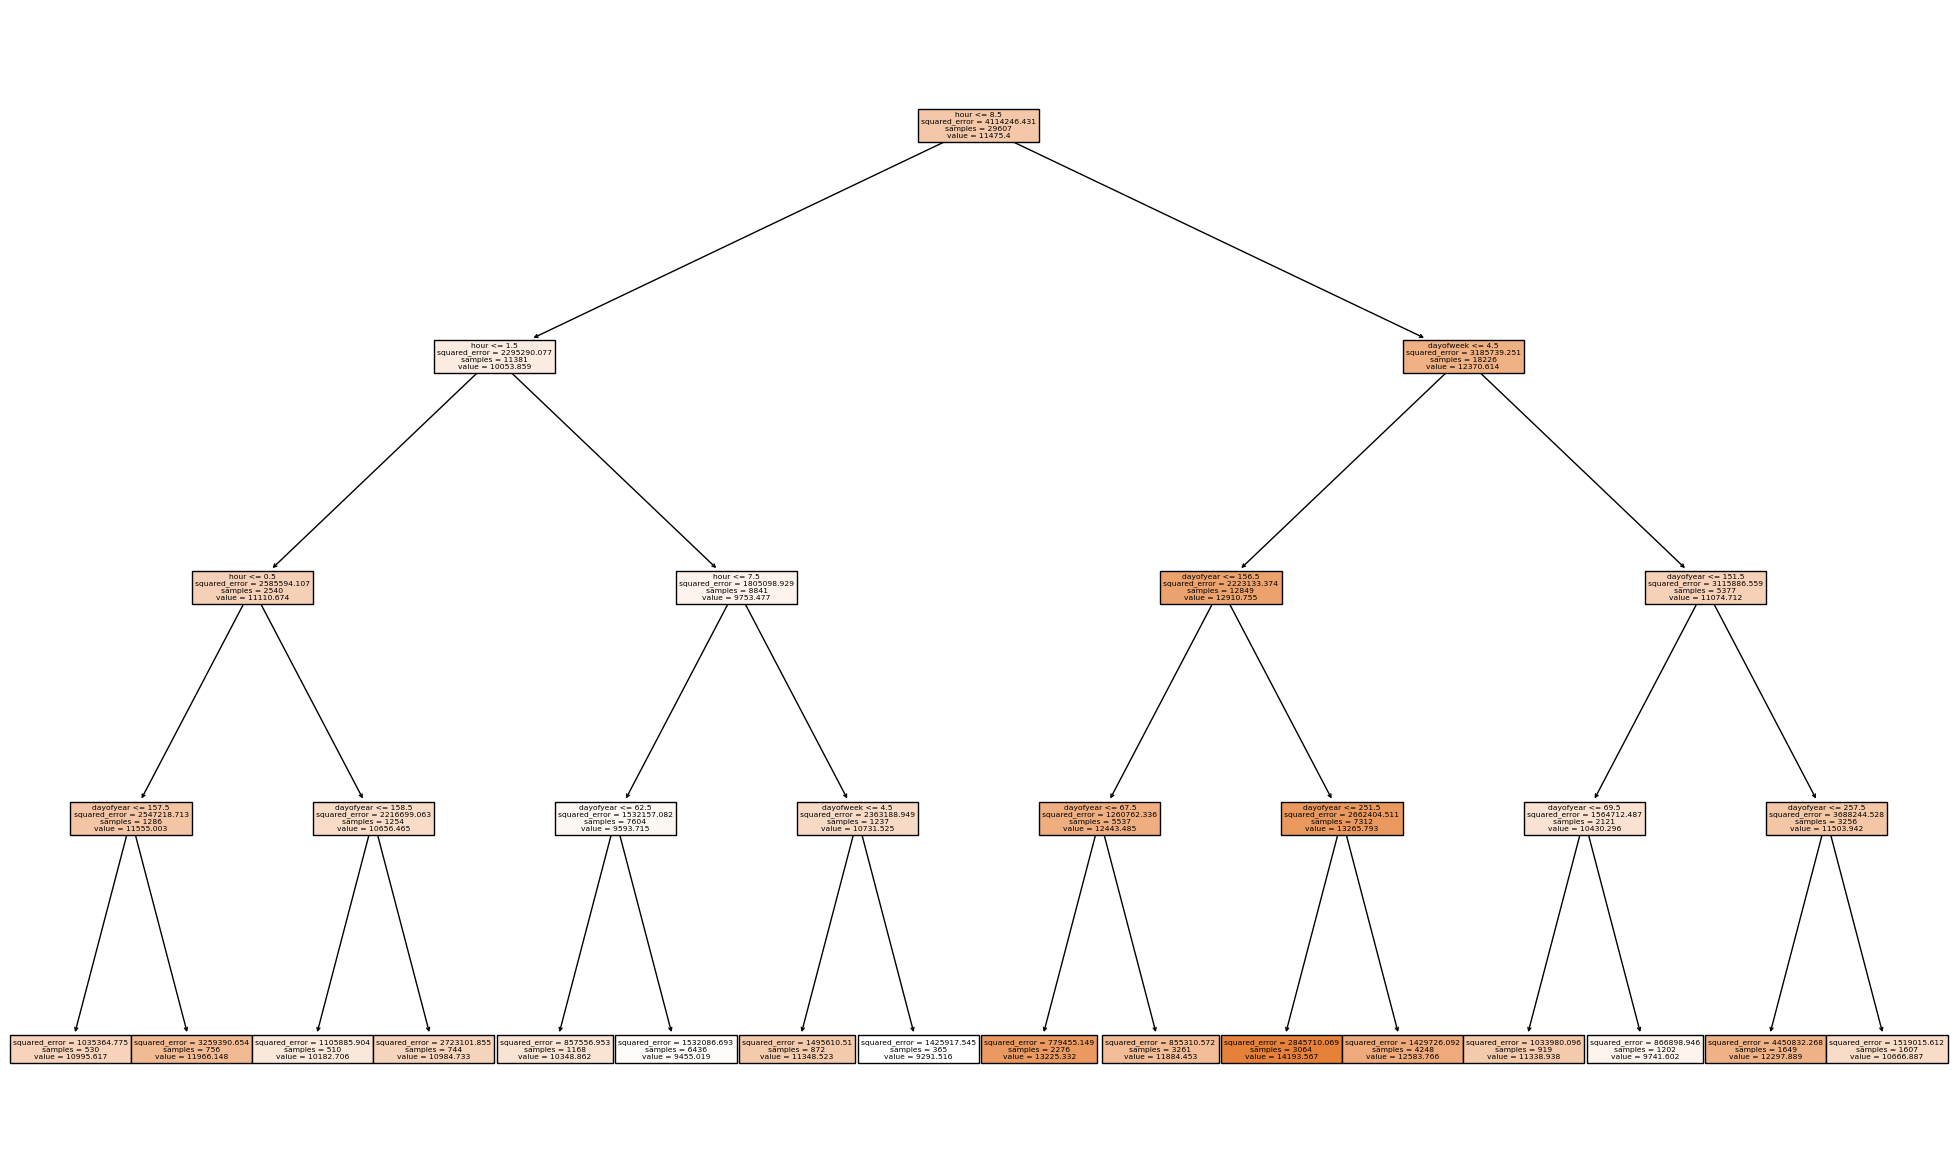

In [54]:
# Call the function to visualize tree from the random forest
visualize_tree_from_random_forest(reg_rf2, 0, X_train2.columns)

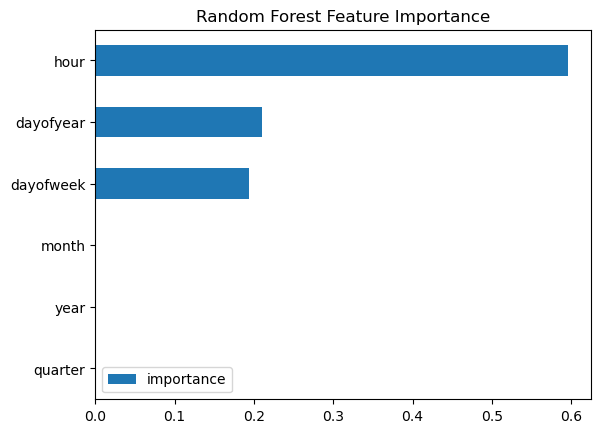

In [55]:
# Call the function to plot the feature importance of the random forest
plot_feature_importance(reg_rf2, X_train2.columns, 'Random Forest Feature Importance')

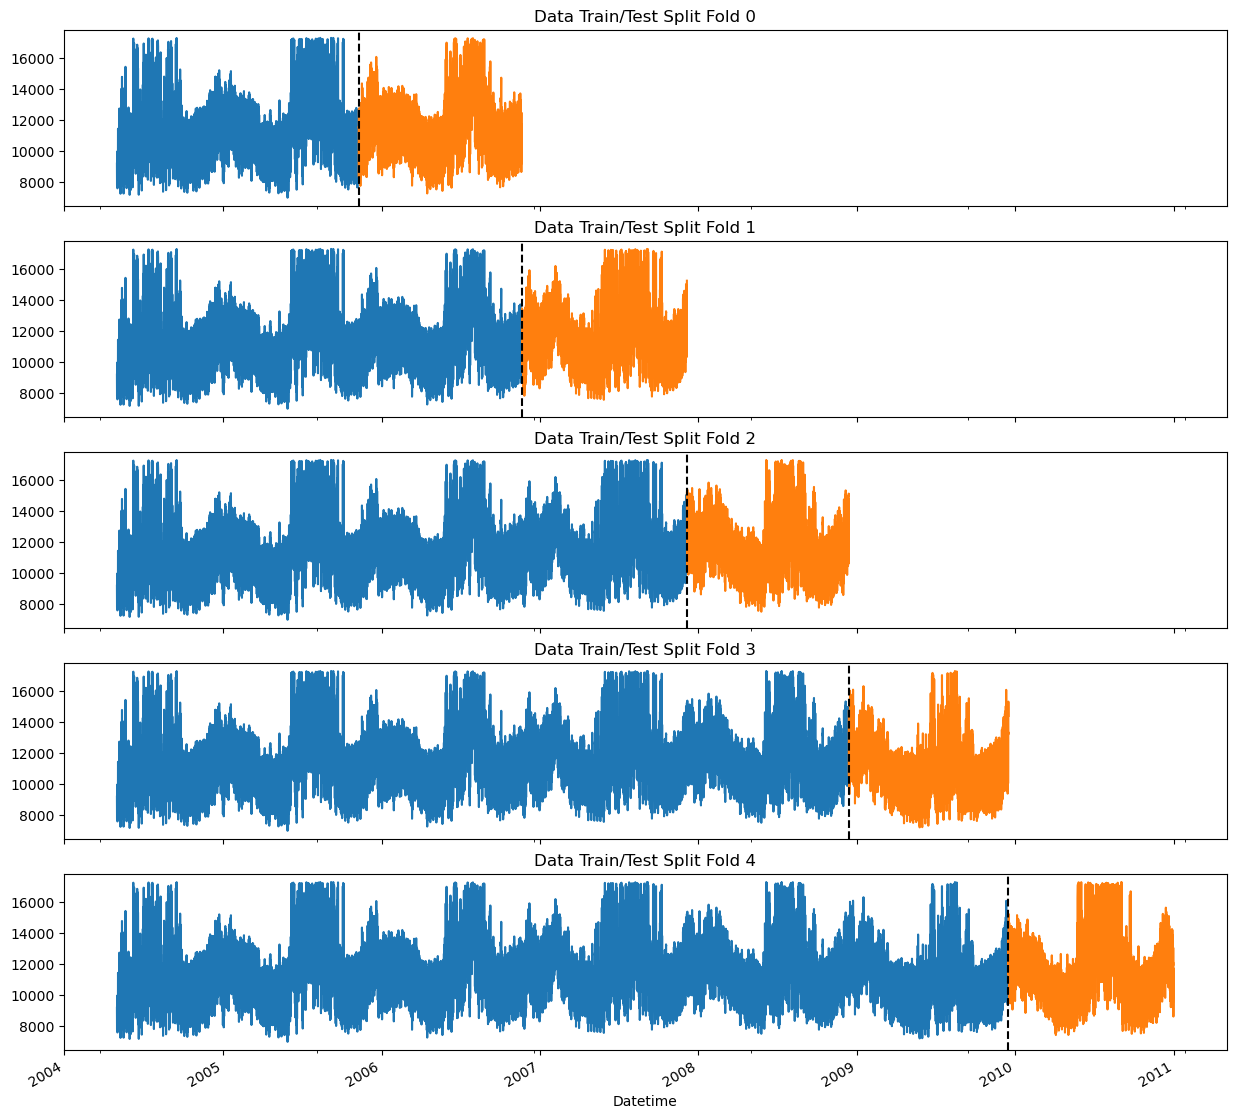

In [58]:
# Plot the time series split for every fold
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df2 = df2.sort_index()
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold2 = 0
for train_idx, val_idx in tss.split(df2):
    train2 = df2.iloc[train_idx]
    test2 = df2.iloc[val_idx]
    train2['NI_MW'].plot(ax=axs[fold2],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold2}')
    test2['NI_MW'].plot(ax=axs[fold2],
                         label='Test Set')
    axs[fold2].axvline(test2.index.min(), color='black', ls='--')
    fold2 += 1
plt.show()

In [59]:
# Use the function that add lags in the dataframe
df2 = add_lags(df2)

In [60]:
# Call the function to perform cross validation
perform_time_series_analysis(df2)

[15:59:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11399.17779	validation_1-rmse:11538.49260
[100]	validation_0-rmse:5257.47889	validation_1-rmse:5067.45131
[200]	validation_0-rmse:2609.78808	validation_1-rmse:2375.78818
[300]	validation_0-rmse:1553.14911	validation_1-rmse:1414.94849
[400]	validation_0-rmse:1190.61126	validation_1-rmse:1186.92861
[482]	validation_0-rmse:1084.54925	validation_1-rmse:1164.17276
[15:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11458.13522	validation_1-rmse:11818.61793
[100]	validation_0-rmse:5273.02822	validation_1-rmse:5484.81652
[200]	validation_0-rmse:26

# Discussion
Dataset is available publicly in [Kaggle.](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption) Among all the available datasets, the Northern Illinois Hub dataset was chosen.

The chosen dataset from Kaggle contains two columns. The first column represents datetime information, while the second column represents energy consumption in megawatts (MW), with total 58450 instances.

The dataset does not require any preprocessing steps before training models, as it already contains continuous values, encompasses hourly consumption data from 2004 to 2011, and does not have any missing values.

##### Visualization of average consumption
1) The higher energy consumption during the period from 5 pm to 10 pm can be attributed to peak demand. During these hours, people typically return home from work, resulting in increased electricity usage for various activities such as cooking, lighting, and entertainment. Additionally, this timeframe coincides with the evening hours when residential and commercial establishments are simultaneously operating, leading to a higher overall demand for electricity.

2) The dataset reveals that the months of June, July, and August consistently exhibit the highest energy consumption levels. This observation can be attributed to the increased usage of HVAC (Heating, Ventilation, and Air Conditioning) systems during the summer months. As temperatures rise, individuals and establishments rely heavily on cooling systems to maintain comfortable indoor environments, resulting in a higher overall demand for electricity. (3rd quarter of the year)

3) The dataset indicates that the average energy consumption remained relatively stable across the years, exhibiting a consistent trend. However, in the last year, a slight decline in energy consumption was observed. This deviation from the previous pattern suggests a potential shift or change in energy usage patterns during that period.

#### Before pre-processing
Prior to any dataset pre-processing, an XGBoost regressor model was trained, yielding a Root Mean Squared Error (RMSE) of 1488.27. Upon visualizing the feature importance of the XGBoost model, it becomes evident that the most influential features, in descending order, are hour, day of the week, day of the year, month, and year.

Afterwards, a Random Forest model was built using the dataset, resulting in a RMSE of 1526.44. The feature importance analysis of the Random Forest model reveals that the most significant features, in descending order, are hour, day of the year, and day of the week.

Finally, a cross-validated model was constructed using 5-fold cross-validation, employing an XGBoost regressor. The average RMSE score across the folds was calculated to be 1378.15.

#### Pre-process (remove outliers)
The dataset utilized was remarkably clean and necessitated minimal preprocessing. The only preprocessing step undertaken involved removing a few outliers. 

Outliers were identified in the dataset by calculating the upper and lower bounds. The lower bound was determined to be 5539.876 and the upper bound was 17310.875. Instances outside these bounds were considered outliers and were subsequently removed from the dataset. 

Dataset had 0 instances below the lower bound and 1816 instances (3,10%) above the upper bound that has been removed.

After removing outliers, the dataset was reevaluated using the same XGBoost regressor model as before. The revised model achieved a RMSE of 1179.41. The feature importance analysis of the updated model indicated that the most significant features, in descending order, were hour, day of the week, day of the year, month, and year.

Following the reevaluation, a Random Forest regressor model was implemented with the updated dataset. The model achieved a RMSE of 1347.36. The feature importance analysis of the Random Forest model revealed that the most influential features, in descending order, were hour, day of the year, and day of the week.

Afterwards, the dataset underwent further evaluation using a cross-validated model that employed an XGBoost regressor. The updated model achieved a RMSE of 1152.40

# Observations
The initial XGBoost regressor model, trained before preprocessing, had an RMSE of 1488.27, after removing outliers and reevaluating the XGBoost model, the RMSE improved to 1179.41, which is 20.75% improvement.

Random forest regressor had worst performance than the XGBoost regressor model with RMSE of 1526.44 and after removing outliers had an RMSE of 1347.36, which is 11.73% improvement.

The best model was the cross-validated XGBoost regressor model with initial RMSE of 1378.15 and after removing outliers 1152.40, which is 16.38% improvement.

The most benefitted model from the pre-processing was the XGBoost regressor model with 20.75% improvement.

The feature importance analysis of the XGBoost regressor model consistently ranked the most influential features as hour, day of the week, day of the year, month, and year, with hour being the most important. These features played a crucial role in capturing the temporal patterns and variations in energy consumption. In the Random Forest model, the feature importance analysis highlighted the significance of hour, day of the year, and day of the week, with hour retaining its position as the most important feature. The reduced feature set in the Random Forest model suggests that these three features alone provide sufficient predictive power for the energy consumption patterns observed in the dataset.